# Финальный проект А/В-тесты

# Описание проекта

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

`Техническое задание`

Название теста: recommender_system_test;

группы: А — контрольная, B — новая платёжная воронка;

дата запуска: 2020-12-07;

дата остановки набора новых пользователей: 2020-12-21;

дата остановки: 2021-01-04;

аудитория: 15% новых пользователей из региона EU;

назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

ожидаемое количество участников теста: 6000

`Описание данных`

`ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год.`

Структура файла:

name — название маркетингового события;

regions — регионы, в которых будет проводиться рекламная кампания;

start_dt — дата начала кампании;

finish_dt — дата завершения кампании.

`final_ab_new_users.csv — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.`

Структура файла:

user_id — идентификатор пользователя;

first_date — дата регистрации;

region — регион пользователя;

device — устройство, с которого происходила регистрация.

`final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.`

Структура файла:

user_id — идентификатор пользователя;

event_dt — дата и время покупки;

event_name — тип события;

details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv — таблица участников тестов.`

Структура файла:

user_id — идентификатор пользователя;

ab_test — название теста;

group — группа пользователя

# Предобработка данных

In [48]:
# импортируем все нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import math as mth
from scipy import stats as st

In [49]:
ab_events = pd.read_csv('/datasets/final_ab_events.csv') # действия новых пользователей в период с 7.12.20-4.01.21
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv') # календарь маркетинговых событий на 2020 год
ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv') # пользователи, зарегистрировавшиеся с 7-21.12.20
ab_participants = pd.read_csv('/datasets/final_ab_participants.csv') # таблица участников тестов

display(marketing_events.head())
display(ab_new_users.head())
display(ab_events.head())
ab_participants.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [50]:
# посмотрим данные по таблицам

marketing_events.info()
ab_new_users.info()
ab_events.info()
ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  obj

В таблице marketing_events:
- привести start_dt, finish_dt к верному типу данных
- столбец regions имеет неудобный формат для дальнейшей работы

В таблице ab_new_users:
- привести first_date к верному типу данных

В таблице ab_events:
- привести event_dt к верному типу данных
- в столбце details есть пропуски

Проверим также дубликаты.

In [51]:
display(marketing_events.duplicated().sum())
display(ab_new_users.duplicated().sum())
display(ab_events.duplicated().sum())
ab_participants.duplicated().sum()

0

0

0

0

In [52]:
# приведем все столбцы (кроме таблицы ab_events) с датами к верному типу

marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])

In [53]:
# датасет ab_events обработаем по другому, так как в нем есть данные о времени. Выделим дату в отдельный столбец

ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'], format='%Y-%m-%d %H:%M:%S')
ab_events['date'] = ab_events['event_dt'].dt.date
ab_events['date'] = pd.to_datetime(ab_events['date'])

In [54]:
# проверим пропуски в таблице ab_events, столбец details

display(ab_events[ab_events['details'].isna() == True]['event_name'].unique())
ab_events[ab_events['details'].isna() == False]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

array(['purchase'], dtype=object)

Мы видим, что пропусков нет только там, где действие - покупка. Значит, мы можем заполнить пропуски 0, так как события, где есть пропуски не скажутся на общей цене.

In [55]:
ab_events['details'] = ab_events['details'].fillna(0)

Обработаем столбец regions в датасете marketing_events для удобства работы.

In [56]:
marketing_events['regions'].unique() # посмотрим виды регионов

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [57]:
# отсортируем регионы функцией

def sort_region(data, region):
    #region = ['EU', 'CIS', 'N.America', 'APAC'] - все виды регионов
    
    if region in data['regions']:
        return 1
    else:
        return 0

marketing_events['EU'] = marketing_events.apply(sort_region, region='EU', axis=1)
marketing_events['SNG'] = marketing_events.apply(sort_region, region='CIS', axis=1)
marketing_events['N.America'] = marketing_events.apply(sort_region, region='N.America', axis=1)
marketing_events['Asia'] = marketing_events.apply(sort_region, region='APAC', axis=1)

In [58]:
marketing_events.head()

,name,regions,start_dt,finish_dt,EU,SNG,N.America,Asia
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,1,0,1,0
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,1,1,1,1
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,1,0,1,0
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,1,1,1,1
4,4th of July Promo,N.America,2020-07-04,2020-07-11,0,0,1,0


Проверим датасеты ab_events и ab_new_users на соответствие тех.заданию.

In [59]:
display(ab_events['event_dt'].min())
display(ab_events['event_dt'].max())
display(ab_new_users['first_date'].min())
ab_new_users['first_date'].max()

Timestamp('2020-12-07 00:00:33')

Timestamp('2020-12-30 23:36:33')

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-23 00:00:00')

Согласно ТЗ, датасет ab_events должен иметь данные с 7.12.20 по 04.01.2021. Однако, мы видим, что данные заканчиваются на 30.12.202. Это явно техническая ошибка при выгрузке данных, так как это новогодние праздники и покупки явно должны были совершаться. Необходимо сообщить тех.специалистам найденную ошибку. Потеря этих данных явно скажется на результатах АВ-теста.

Обратная же ситуация по датасету ab_new_users. Данные должны были иметь крайнюю точку 21.12.20, однако в таблице есть данные также за 22 и 23 декабря. Этоо не корректно, необходимо убрать данные за этот период, чтобы было соответствие ТЗ.

In [60]:
ab_new_users = ab_new_users.query('first_date <= "2020-12-21"')
ab_new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Мы полностью обработали данные, теперь они готовы к анализу.

# Оценим корректность проведения теста

## Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания

`Напомним эти пункты:`

1) Название теста: recommender_system_test;

2) группы: А — контрольная, B — новая платёжная воронка;

3) дата запуска: 2020-12-07;

4) дата остановки набора новых пользователей: 2020-12-21;

5) дата остановки: 2021-01-04;

6) аудитория: 15% новых пользователей из региона EU;

7) назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

8) ожидаемое количество участников теста: 6000

Проверим `1` пункт.

In [61]:
ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

У нас есть два вида теста. Посмотрим, как распределяются данные между пользователями.

In [62]:
data = ab_new_users.merge(ab_participants, on='user_id')
data.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
4,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test


Во-первых, у нас есть два теста, а так как по ТЗ нас интересует только `recommender_system_test`, то ниже очистим данные и оставим только один тест. Во-вторых, в таблице ab_new_users у нас есть данные по пользователям, которые принимали участие в другом тесте `interface_eu_test`, этот тест, как и пользователей, принимавших в нем участие, рассматривать не будем.

Очистим данные.

In [63]:
data = data.query('ab_test == "recommender_system_test"')

Проверим пункт `2`:

In [64]:
A_data = data.query('group == "A"')
B_data = data.query('group == "B"')

In [65]:
check = A_data.merge(B_data, on='user_id') # проверим, есть ли пересечение по пользователям в А и В тесте
check

,user_id,first_date_x,region_x,device_x,group_x,ab_test_x,first_date_y,region_y,device_y,group_y,ab_test_y


Пересечений по группам А и В между пользователями нет. Соотношение кол-ва пользователей между группами составляет 25%. Это достаточно большой показатель, однако, к сожалению, мы никак не можем разделить данные, поэтому оставляем так.

Пункты `3`, `4`, `5` мы проверили выше и очистили данные в соответствии с условиями ТЗ.

Проверим пункт `6`:

In [66]:
len(data['user_id'].unique()) # новых пользователей всего

6701

In [67]:
len(data.query('region == "EU"')) # новых пользователей из EU

6351

In [68]:
print('Новых пользователей из региона EU: {:.2f}'.format(len(data.query('region == "EU"')) / len(data['user_id'].unique())))

Новых пользователей из региона EU: 0.95


По ТЗ нам необходимо только 15% таких пользователей, а у нас получилось целых 95%. Данные мы никак "подогнать", к сожалению, не можем. Работаем с тем, что есть.

Проверим пункт `8`.

Выше у нас получилось, что в тесте участвует 6701 новый пользователь. Ожидалось 6000, но разница не критична. Думаю, с такими данными можно работать.

## Проверьте равномерность распределения по тестовым группам и правильность их формирования

In [69]:
data.groupby('group').agg({'user_id': 'count'}) # посмотрим соотношение кол-ва пользователей по группам

,user_id
group,
A,3824
B,2877


Выше мы проверяли, что у нас нет пользователей, которые числятся в обеих группах.
Проверим, по всем ли пользователям есть события и как они распределяются.

In [70]:
data = data.merge(ab_events, on='user_id')
event_check = data.groupby(['user_id', 'event_name']).agg({'group': 'count'}).reset_index()
event_check.query('group == 0')

,user_id,event_name,group


In [71]:
data.groupby('event_name').agg({'user_id': 'count'}).sort_values('user_id')

,user_id
event_name,
product_cart,3247
purchase,3331
product_page,6930
login,11190


У нас нет пользователей, по которым отсутствуют события - это хорошо. Однако, у нас кол-во пользователей, по которым есть событие Продуктовая корзина превышает кол-во пользователей, совершивших покупку.

Вероятно, это объясняется тем, что часть пользователей перешла на покупку по прямой ссылке, минуя Продуктовую корзину. В целом, не криично.

# Исследовательский анализ данных

## Количество событий на пользователя одинаково распределены в выборках?

Посмотрим как распределено количество событий на одного пользователя в каждой группе.

In [72]:
events_per_user_A = data[data['group'] == "A"].groupby('user_id').agg({'event_name': 'count'}).reset_index()
events_per_user_B = data[data['group'] == "B"].groupby('user_id').agg({'event_name': 'count'}).reset_index()

In [73]:
display(events_per_user_A.describe())
events_per_user_B.describe()

,event_name
count,2747.000000
mean,7.027303
std,3.868983
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


,event_name
count,928.000000
mean,5.812500
std,3.483878
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,28.000000


Данные по группам сильно отличаются в количественном отношении. Также, максимальные значения в обеих группах сильно больше третьего квартиля, а значит, в данных есть выбросы. 

Удалим данные, которые находятся за пределами нормальных значений (выше 95 перцентиля).

In [74]:
events_per_user_A = events_per_user_A[events_per_user_A['event_name'] <= events_per_user_A['event_name'].quantile(0.95)]
events_per_user_B = events_per_user_B[events_per_user_B['event_name'] <= events_per_user_B['event_name'].quantile(0.95)]

Построим распределение по очищенным данным.

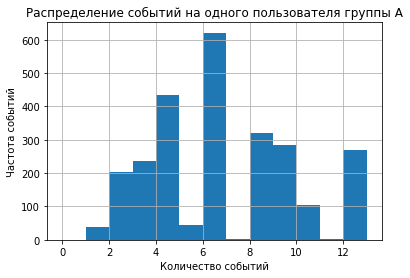

In [75]:
pd.Series(events_per_user_A['event_name']).hist(range = (0, 13), bins=13)
plt.title('Распределение событий на одного пользователя группы А')
plt.xlabel('Количество событий')
plt.ylabel('Частота событий')
plt.show()

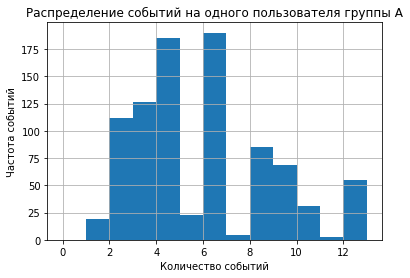

In [76]:
pd.Series(events_per_user_B['event_name']).hist(range = (0, 13), bins=13)
plt.title('Распределение событий на одного пользователя группы А')
plt.xlabel('Количество событий')
plt.ylabel('Частота событий')
plt.show()

In [77]:
display(events_per_user_A.describe())
events_per_user_B.describe()

,event_name
count,2660.000000
mean,6.667669
std,3.353904
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,15.000000


,event_name
count,902.000000
mean,5.485588
std,2.873839
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,12.000000


По очищенным данным у нас получилось, что максимальное кол-во событий на пользователя в обеих группах - 12. Среднее тоже не сильно отличается, в группе А и В 6.35 и 5.48 соответственно. Однако, данные отличаются количественно: 2562 пользователя и 902 соответственно в группах А и В.

Уберем также из основной таблицы data выбросы.

In [78]:
events_per_user_A_B = events_per_user_A['user_id'].append(events_per_user_B['user_id'])

In [79]:
data = data.merge(events_per_user_A_B, on='user_id')
data.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,date
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,0.0,2020-12-07
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,0.0,2020-12-07
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,0.0,2020-12-07
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,0.0,2020-12-08
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,0.0,2020-12-10


## Как число событий в выборках распределено по дням?

In [80]:
events_per_days_A = data[data['group'] == "A"].groupby('date').agg({'event_name': 'count'}).reset_index()
events_per_days_B = data[data['group'] == "B"].groupby('date').agg({'event_name': 'count'}).reset_index()

Посмотрим наглядно как распределены данные.

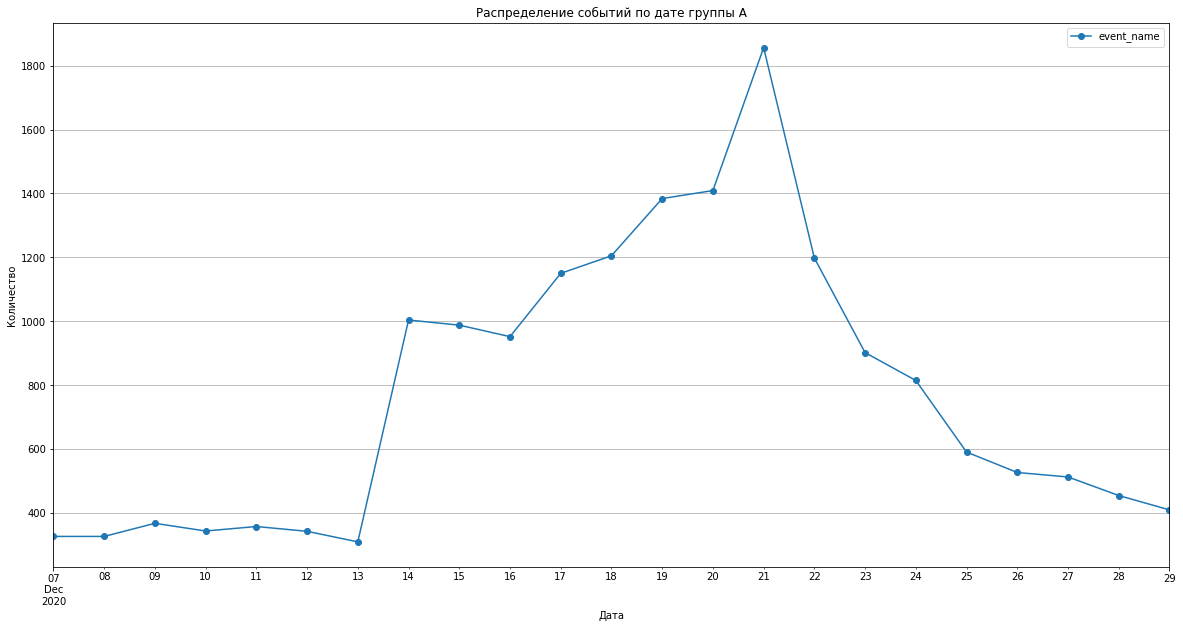

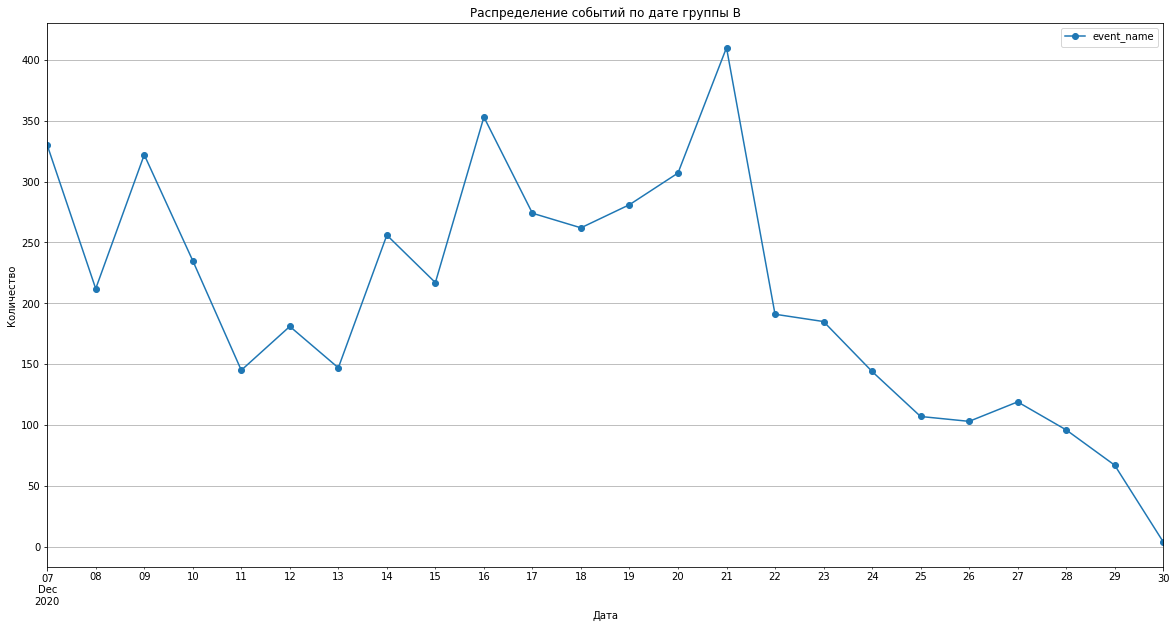

In [81]:
events_per_days_A.plot(x='date', y='event_name', rot=0, figsize=(20, 10), grid=True, marker='o')
plt.title('Распределение событий по дате группы А')
plt.xlabel('Дата')
plt.ylabel('Количество');
events_per_days_B.plot(x='date', y='event_name', rot=0, figsize=(20, 10), grid=True, marker='o')
plt.title('Распределение событий по дате группы В')
plt.xlabel('Дата')
plt.ylabel('Количество');

Из графиков видно:

- Дата остановки проведения теста 04.01.2021, однако для группы А эта дата 29.12.2020, для группы В - 30.12.2020
- В группе А есть резкий скачок в период 13-14.12.2020
- В период до 13.12.2020 график сильно асинхронны, то есть график группы А визуально совершенно не похож на группу В. Это интересное наблюдение, по идее графики должны хотя бы примерно повторять форму друг друга

## Как меняется конверсия в воронке в выборках на разных этапах?

У нас есть следующие этапы (расположены в логической последовательности):
- регистрация пользователя (login)
- страница с товарами (product_page)
- корзина (product_cart)
- покупка (purchase)

При этом, как мы выяснили выше, есть пользователи, которые переходят (вероятнее всего) по прямой ссылке на покупку, минуя корзину. В остльном воронка продаж соответствует ее классическому представлению.

In [82]:
# отсортируем события по числу пользователей

event_funnel_A = data[data['group'] == "A"].groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
event_funnel_B = data[data['group'] == "B"].groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()

# посчитаем долю
event_funnel_A['percent'] = event_funnel_A['user_id'] / data[data['group'] == "A"]['user_id'].nunique() * 100
event_funnel_B['percent'] = event_funnel_B['user_id'] / data[data['group'] == "B"]['user_id'].nunique() * 100

display(event_funnel_A)
event_funnel_B

,event_name,user_id,percent
0,login,2660,100.000000
1,product_page,1693,63.646617
2,purchase,797,29.962406
3,product_cart,749,28.157895


,event_name,user_id,percent
0,login,902,100.000000
1,product_page,499,55.321508
2,purchase,239,26.496674
3,product_cart,238,26.385809


Построим наглядно воронку событий по каждой группе.

In [83]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = event_funnel_A['event_name'],
    x = event_funnel_A['user_id'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'Группа В',
    orientation = "h",
    y = event_funnel_B['event_name'],
    x = event_funnel_B['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(title='Воронка событий по группам А и В', title_x=0.55)
fig.show()

Построим также общую воронку по двум группам суммарно.

In [84]:
event_funnel = data.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
event_funnel['percent'] = event_funnel['user_id'] / data['user_id'].nunique() * 100
event_funnel

,event_name,user_id,percent
0,login,3562,100.000000
1,product_page,2192,61.538462
2,purchase,1036,29.084784
3,product_cart,987,27.709152


In [85]:
fig = go.Figure(
go.Funnel(
    y = event_funnel['event_name'],
    x = event_funnel['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": "#1c1847"}))
fig.update_layout(title='Воронка событий', title_x=0.55)
fig.show()

Мы видим, что из общего количества пришедших пользователей, у нас 47% совершают покупку. Однако, воронка имеет не классический вид ввиду наличия пользователей, пришедших по прямой ссылке на страницу purchase.

Если говорить о различиях по группам, то группа А явно доминирует над группой В в количественном отношении, одно в процентном отншении совершения покупки цифры схожие.

## Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Выше в разных пунктах проекта мы избавились от пропусков, выбросов, данных, не соответствующих ТЗ. Данные в этом плане у нас чистые.

Однако, на воронке выше видно явное не соответствие воронки ее, событие purchase должно быть последним. И должна быть соблюдена логическая цепочка воронки продаж.

In [86]:
data.groupby('event_name').agg({'user_id': 'nunique'})

,user_id
event_name,
login,3562
product_cart,987
product_page,2192
purchase,1036


Чтобы привести в соответствие наши данные, исключим все события, цикл которых превышает 14 дней (так как именно столько в чистом виде должен длиться тест согласно ТЗ).

In [87]:
def cycle(data):
    time = data['date'] - data['first_date']
    if time.days <= 14:
        return 1
    else:
        return 0

In [88]:
data['full_cycle'] = data.apply(cycle, axis=1)
display(len(data.query('full_cycle == 1')))
len(data.query('full_cycle == 0'))

22099

585

In [89]:
data = data.query('full_cycle == 1')
data

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,date,full_cycle
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,0.0,2020-12-07,1
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,0.0,2020-12-07,1
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,0.0,2020-12-07,1
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,0.0,2020-12-08,1
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,0.0,2020-12-10,1
...,...,...,...,...,...,...,...,...,...,...,...
22679,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,product_page,0.0,2020-12-21,1
22680,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:51,product_page,0.0,2020-12-24,1
22681,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,login,0.0,2020-12-20,1
22682,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,login,0.0,2020-12-21,1


In [90]:
data.groupby('event_name').agg({'user_id': 'nunique'}).sort_values('user_id')

,user_id
event_name,
product_cart,987
purchase,1036
product_page,2192
login,3561


Ожидаемые результаты не опреавдались, количество пользователей после очистки данных не изменилось.

# Оцените результаты A/B-тестирования

## Что можно сказать про результаты A/В-тестирования?

В рамках А\В-тестов мы оценивали эффективность изменений, связанных с внедрением улучшенной рекомендательной системы.
Ее наглядно можно оценить воронкой продаж. Мы строили воронку в п.6.3.

Наглядно видно, что результат группы В по продажам лучше на 1%, чем в группе А. Однако, стоит сделать скидку на большое различие в количественном отношении между группами. В идеальных условиях такого быть не должно, количественно данные обеих групп не должны сильно различаться.

## Проверьте статистическую разницу долей z-критерием

H0: Доля пользователей в одной группе равна доле пользователей в другой группы для конкретного события.

Н1: Доля пользователей в одной группе не равна доле пользователей в другой группы для конкретного события.

Подготовим сводные таблицы для проведения статистического теста.

In [91]:
d = data[data['group'] == "A"].pivot_table(index='event_name', columns='group', values='user_id',aggfunc='nunique')
d1 = data[data['group'] == "B"].pivot_table(index='event_name', columns='group', values='user_id',aggfunc='nunique')
d = d.merge(d1, on='event_name')
d

group,A,B
event_name,,
login,2660,901
product_cart,749,238
product_page,1693,499
purchase,797,239


In [92]:
df_full = pd.pivot_table(data, index='group', values = 'user_id', aggfunc='nunique').reset_index()
df_full = df_full.set_index(df_full.columns[0])
df_full

,user_id
group,
A,2660
B,902


In [93]:
def test(exp1, exp2, event, alpha): 
    success_exp1 = d.loc[event, exp1]
    success_exp2 = d.loc[event, exp2]
    all_users_exp1 = df_full.loc[exp1, 'user_id']
    all_users_exp2 = df_full.loc[exp2, 'user_id']
  
    p1 = success_exp1 / all_users_exp1 
    p2 = success_exp2 / all_users_exp2 
    
    difference = p1 - p2
    p_combined = (success_exp1 + success_exp2) / (all_users_exp1 + all_users_exp2) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / all_users_exp1 + 1 / all_users_exp2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    bonferroni_alpha = alpha / 4
    
    print('Для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [94]:
for event in d.index:
    test('A', 'B', event, 0.05)
    print()

Для  A и B, событие: login, p-значение: 0.09
Не получилось отвергнуть нулевую гипотезу

Для  A и B, событие: product_cart, p-значение: 0.30
Не получилось отвергнуть нулевую гипотезу

Для  A и B, событие: product_page, p-значение: 0.00
Отвергаем нулевую гипотезу

Для  A и B, событие: purchase, p-значение: 0.05
Не получилось отвергнуть нулевую гипотезу



По всем событиям, кроме Продуктовой корзины у нас получилось, что нельзя отвергнуть нулевюу гипотезу. То есть нельзя говорить о различии долей в группах. Обратная же ситуация по событию Продуктовая корзина.

# Опишите выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста

По результатам оценки A/B-теста можно сказать следующее:

- в данных имелись пропуски в столбце details, который отражает дополнительные данные. Пропуски отсутствуют только у событий, не относящихся к покупке, поэтому пропущенные значения заменили 0
- дата остановки теста (04.01.2021) не совпадает с датой последнего события (30.12.2020\29.12.2020). Это не корректно. Вероятно, имеет место быть техническая проблема, потому что в разгар Новогодних праздников люди должны были совершать не малое количество покупок. Необходимо уточнить у заказчика почему нет событий за период с 31.12.2020 по 04.01.2021. Так же, отметили, что для разных групп А и В разные даты окончания, 29 и 30.12 соответственно. Это тоже не корректно
- при анализе распределения событий по дням, выявлен резкий скачок в даты 13-14.12 по событиям пользователей группы A
- в группах А и B нет одних и тех же пользователей, это хорошо

Результаты проверки равенства долей:

по всем событиям, кроме Product_page, нет статистических различий между долями. 

Общие рекомендации:

Проведенный А/В-тест сложно назвать корректным. Не корректная выгрузка данных (период за январь не учетен), достаточно большая разница в распределении поккупателей между А и В группами (хотя стат.тест это не подтвердил, но все же лучше иметь меньшую разницу), гораздо большией % пользователей из Европы (что не отвечает требованиям ТЗ), пользователей, совершивших покупку по прямой ссылке много, в связи с чем нарушается воронка продаж.

Лучше еще раз провести тест в другой временной промежуток, с учетом всех технических недоработок, которые присутствовали в этом тесте.